산업 데이터 특화 전처리 파이프라인
- 시계열 데이터의 계절성 및 트렌드 분해
- 센서 데이터의 노이즈 제거
- 공정 변수 간 상관관계 분석
- 품질 관리 관점에서의 이상치 처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('default')


In [2]:
class IndustrialDataPreprocessor:
    """산업 데이터 전용 전처리 파이프라인"""
    
    def __init__(self):
        self.scalers = {}
        self.noise_params = {}
        self.control_limits = {}
        
    def simulate_industrial_data(self, n_samples=2000):
        """실제 산업 환경을 모방한 시뮬레이션 데이터 생성"""
        
        np.random.seed(42)
        time_index = pd.date_range('2024-01-01', periods=n_samples, freq='H')
        
        # 1. 기본 시계열 패턴 생성
        t = np.arange(n_samples)
        
        # 일일 사이클 (24시간)
        daily_cycle = 5 * np.sin(2 * np.pi * t / 24)
        
        # 주간 사이클 (7일)
        weekly_cycle = 3 * np.sin(2 * np.pi * t / (24 * 7))
        
        # 장기 트렌드
        trend = 0.001 * t + 2 * np.sin(2 * np.pi * t / (24 * 30))
        
        # 2. 온도 데이터 (기본 패턴 + 노이즈)
        temperature_base = 75 + daily_cycle + weekly_cycle + trend
        temperature_noise = np.random.normal(0, 1.5, n_samples)
        temperature = temperature_base + temperature_noise
        
        # 설비 가동/정지에 따른 급격한 변화
        shutdown_periods = np.random.choice(n_samples, 50, replace=False)
        for period in shutdown_periods:
            if period < n_samples - 10:
                temperature[period:period+10] -= np.random.uniform(10, 20)
        
        # 3. 압력 데이터 (온도와 상관관계 + 독립적 변동)
        pressure_base = 120 + 0.8 * (temperature - 75) + np.random.normal(0, 3, n_samples)
        
        # 압력 센서 드리프트 (시간에 따른 편향)
        pressure_drift = 0.002 * t * np.random.normal(1, 0.1, n_samples)
        pressure = pressure_base + pressure_drift
        
        # 4. 진동 데이터 (고주파 노이즈 + 기계 상태)
        vibration_base = 2.5 + 0.5 * np.sin(2 * np.pi * t / 12)  # 반일 사이클
        
        # 고주파 노이즈 (실제 진동)
        high_freq_noise = np.random.normal(0, 0.3, n_samples)
        
        # 베어링 불량으로 인한 이상 진동
        bearing_fault_periods = np.random.choice(n_samples, 30, replace=False)
        bearing_fault = np.zeros(n_samples)
        for period in bearing_fault_periods:
            if period < n_samples - 20:
                fault_signal = 2 * np.sin(2 * np.pi * np.arange(20) * 0.1) * np.exp(-np.arange(20) * 0.1)
                bearing_fault[period:period+20] = fault_signal
        
        vibration = vibration_base + high_freq_noise + bearing_fault
        
        # 5. 품질 지표 (다른 변수들의 복합 함수)
        quality_base = 85 + 0.1 * (temperature - 75) - 0.05 * (pressure - 120) - 2 * np.abs(vibration - 2.5)
        quality_noise = np.random.normal(0, 2, n_samples)
        quality = quality_base + quality_noise
        
        # 품질은 0-100 범위로 제한
        quality = np.clip(quality, 0, 100)
        
        # 6. 생산량 (시간대별 변동)
        production_pattern = 100 + 20 * np.sin(2 * np.pi * (t % 24) / 24)  # 시간대별 변동
        production_random = np.random.normal(0, 10, n_samples)
        production = production_pattern + production_random
        production = np.clip(production, 0, None)  # 음수 제거
        
        # 데이터프레임 생성
        df = pd.DataFrame({
            'timestamp': time_index,
            'temperature': temperature,
            'pressure': pressure,
            'vibration': vibration,
            'quality': quality,
            'production': production
        })
        
        return df
    
    def detect_sensor_anomalies(self, data, column, method='statistical'):
        """센서 이상 탐지 (드리프트, 스파이크, 스턱 등)"""
        
        print(f"\n=== {column} 센서 이상 탐지 ===")
        
        if method == 'statistical':
            # 1. 통계적 이상치 (Z-score)
            z_scores = np.abs(stats.zscore(data))
            outliers_stat = z_scores > 3
            
            # 2. 연속적 변화율 분석 (급격한 변화)
            diff = np.diff(data)
            diff_z = np.abs(stats.zscore(diff))
            rapid_changes = np.zeros(len(data), dtype=bool)
            rapid_changes[1:] = diff_z > 3
            
            # 3. 스턱 밸류 탐지 (동일한 값이 연속으로 나타남)
            stuck_values = np.zeros(len(data), dtype=bool)
            for i in range(5, len(data)):
                if len(set(data[i-5:i])) == 1:  # 5개 연속 동일값
                    stuck_values[i-5:i] = True
            
            print(f"통계적 이상치: {outliers_stat.sum()}개 ({outliers_stat.sum()/len(data)*100:.2f}%)")
            print(f"급격한 변화: {rapid_changes.sum()}개 ({rapid_changes.sum()/len(data)*100:.2f}%)")
            print(f"스턱 밸류: {stuck_values.sum()}개 ({stuck_values.sum()/len(data)*100:.2f}%)")
            
            return {
                'statistical_outliers': outliers_stat,
                'rapid_changes': rapid_changes,
                'stuck_values': stuck_values,
                'any_anomaly': outliers_stat | rapid_changes | stuck_values
            }
    
    def remove_noise(self, data, method='savgol', **kwargs):
        """노이즈 제거"""
        
        if method == 'savgol':
            # Savitzky-Golay 필터 (다항식 평활화)
            window_length = kwargs.get('window_length', 11)
            polyorder = kwargs.get('polyorder', 3)
            
            if len(data) < window_length:
                window_length = len(data) // 2 * 2 + 1  # 홀수로 조정
            
            smoothed = signal.savgol_filter(data, window_length, polyorder)
            
        elif method == 'moving_average':
            # 이동평균
            window = kwargs.get('window', 5)
            smoothed = pd.Series(data).rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
            smoothed = smoothed.values
            
        elif method == 'lowpass':
            # 저주파 통과 필터
            cutoff = kwargs.get('cutoff', 0.1)  # 정규화된 주파수
            b, a = signal.butter(4, cutoff, btype='low')
            smoothed = signal.filtfilt(b, a, data)
            
        return smoothed
    
    def analyze_frequency_domain(self, data, sampling_rate=1.0):
        """주파수 영역 분석"""
        
        # FFT 계산
        fft_values = fft(data)
        frequencies = fftfreq(len(data), 1/sampling_rate)
        
        # 파워 스펙트럼
        power_spectrum = np.abs(fft_values) ** 2
        
        # 주요 주파수 성분 찾기
        positive_freq_idx = frequencies > 0
        positive_frequencies = frequencies[positive_freq_idx]
        positive_power = power_spectrum[positive_freq_idx]
        
        # 상위 5개 주파수 성분
        top_indices = np.argsort(positive_power)[-5:][::-1]
        dominant_frequencies = positive_frequencies[top_indices]
        dominant_power = positive_power[top_indices]
        
        return {
            'frequencies': frequencies,
            'power_spectrum': power_spectrum,
            'dominant_frequencies': dominant_frequencies,
            'dominant_power': dominant_power
        }
    
    def statistical_process_control(self, data, column_name):
        """통계적 공정 관리 (SPC) 차트"""
        
        mean_val = np.mean(data)
        std_val = np.std(data)
        
        # 관리한계 계산
        ucl = mean_val + 3 * std_val  # 상부 관리한계
        lcl = mean_val - 3 * std_val  # 하부 관리한계
        
        # 관리상태 벗어남 탐지
        out_of_control = (data > ucl) | (data < lcl)
        
        # 런 테스트 (연속적 패턴)
        above_mean = data > mean_val
        runs = []
        current_run = 1
        
        for i in range(1, len(above_mean)):
            if above_mean[i] == above_mean[i-1]:
                current_run += 1
            else:
                runs.append(current_run)
                current_run = 1
        runs.append(current_run)
        
        # 7개 이상 연속으로 같은 쪽에 있으면 이상
        long_runs = any(run >= 7 for run in runs)
        
        self.control_limits[column_name] = {
            'mean': mean_val,
            'std': std_val,
            'ucl': ucl,
            'lcl': lcl
        }
        
        print(f"\n=== {column_name} SPC 분석 ===")
        print(f"평균: {mean_val:.4f}")
        print(f"표준편차: {std_val:.4f}")
        print(f"상부 관리한계 (UCL): {ucl:.4f}")
        print(f"하부 관리한계 (LCL): {lcl:.4f}")
        print(f"관리한계 벗어남: {out_of_control.sum()}개 포인트")
        print(f"긴 런 존재: {'예' if long_runs else '아니오'}")
        
        return {
            'out_of_control': out_of_control,
            'long_runs': long_runs,
            'control_limits': self.control_limits[column_name]
        }


1. 시뮬레이션 데이터 생성

In [3]:
print("=== 산업 데이터 특화 전처리 파이프라인 실습 ===")
preprocessor = IndustrialDataPreprocessor()
industrial_data = preprocessor.simulate_industrial_data(2000)

print(f"생성된 데이터 크기: {industrial_data.shape}")
print("\n데이터 개요:")
print(industrial_data.describe())

=== 산업 데이터 특화 전처리 파이프라인 실습 ===
생성된 데이터 크기: (2000, 6)

데이터 개요:
                           timestamp  temperature     pressure    vibration  \
count                           2000  2000.000000  2000.000000  2000.000000   
mean   2024-02-11 15:29:59.999999744    72.671715   120.118630     2.538335   
min              2024-01-01 00:00:00    17.290916    72.183358     0.532957   
25%              2024-01-21 19:45:00    69.291151   116.452489     2.134337   
50%              2024-02-11 15:30:00    74.271220   121.241738     2.521963   
75%              2024-03-03 11:15:00    78.238979   125.027830     2.914172   
max              2024-03-24 07:00:00    88.293543   137.222257     4.847923   
std                              NaN     8.575320     7.556653     0.584483   

           quality   production  
count  2000.000000  2000.000000  
mean     83.817985   100.379137  
min      75.886094    53.200155  
25%      82.423747    86.624590  
50%      83.863632   100.598092  
75%      85.242027   1

2. 센서 이상 탐지

In [4]:
temp_anomalies = preprocessor.detect_sensor_anomalies(
    industrial_data['temperature'], 'Temperature'
)

vibration_anomalies = preprocessor.detect_sensor_anomalies(
    industrial_data['vibration'], 'Vibration'
)



=== Temperature 센서 이상 탐지 ===
통계적 이상치: 30개 (1.50%)
급격한 변화: 61개 (3.05%)
스턱 밸류: 0개 (0.00%)

=== Vibration 센서 이상 탐지 ===
통계적 이상치: 19개 (0.95%)
급격한 변화: 7개 (0.35%)
스턱 밸류: 0개 (0.00%)


3. 노이즈 제거 비교

In [6]:
# 원본 진동 데이터
original_vibration = industrial_data['vibration'].values

# 다양한 노이즈 제거 방법 적용
smoothed_savgol = preprocessor.remove_noise(original_vibration, 'savgol', window_length=11, polyorder=3)
smoothed_ma = preprocessor.remove_noise(original_vibration, 'moving_average', window=5)
smoothed_lowpass = preprocessor.remove_noise(original_vibration, 'lowpass', cutoff=0.05)

# 노이즈 제거 효과 평가
original_std = np.std(original_vibration)
savgol_std = np.std(smoothed_savgol)
ma_std = np.std(smoothed_ma)
lowpass_std = np.std(smoothed_lowpass)

print(f"원본 표준편차: {original_std:.4f}")
print(f"Savitzky-Golay 후: {savgol_std:.4f} (감소: {(1-savgol_std/original_std)*100:.1f}%)")
print(f"이동평균 후: {ma_std:.4f} (감소: {(1-ma_std/original_std)*100:.1f}%)")
print(f"저주파 필터 후: {lowpass_std:.4f} (감소: {(1-lowpass_std/original_std)*100:.1f}%)")

원본 표준편차: 0.5843
Savitzky-Golay 후: 0.4096 (감소: 29.9%)
이동평균 후: 0.3796 (감소: 35.0%)
저주파 필터 후: 0.0877 (감소: 85.0%)


4. 주파수 영역 분석

In [7]:
freq_analysis = preprocessor.analyze_frequency_domain(original_vibration, sampling_rate=1.0)

print(f"\n=== 진동 데이터 주파수 분석 ===")
print("주요 주파수 성분:")
for i, (freq, power) in enumerate(zip(freq_analysis['dominant_frequencies'], 
                                    freq_analysis['dominant_power'])):
    print(f"{i+1}. 주파수: {freq:.4f} Hz, 파워: {power:.2e}")


=== 진동 데이터 주파수 분석 ===
주요 주파수 성분:
1. 주파수: 0.0835 Hz, 파워: 1.46e+05
2. 주파수: 0.0830 Hz, 파워: 4.01e+04
3. 주파수: 0.0840 Hz, 파워: 2.22e+04
4. 주파수: 0.0825 Hz, 파워: 1.43e+04
5. 주파수: 0.0785 Hz, 파워: 9.96e+03


5. 통계적 공정 관리

In [8]:
temp_spc = preprocessor.statistical_process_control(industrial_data['temperature'], 'Temperature')
quality_spc = preprocessor.statistical_process_control(industrial_data['quality'], 'Quality')


=== Temperature SPC 분석 ===
평균: 72.6717
표준편차: 8.5732
상부 관리한계 (UCL): 98.3912
하부 관리한계 (LCL): 46.9522
관리한계 벗어남: 30개 포인트
긴 런 존재: 예

=== Quality SPC 분석 ===
평균: 83.8180
표준편차: 2.2067
상부 관리한계 (UCL): 90.4381
하부 관리한계 (LCL): 77.1978
관리한계 벗어남: 7개 포인트
긴 런 존재: 예


6. 상관관계 분석

In [9]:
print(f"\n=== 공정 변수 간 상관관계 분석 ===")
correlation_matrix = industrial_data[['temperature', 'pressure', 'vibration', 'quality', 'production']].corr()
print(correlation_matrix.round(3))

# 강한 상관관계 식별
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            strong_correlations.append({
                'var1': correlation_matrix.columns[i],
                'var2': correlation_matrix.columns[j],
                'correlation': corr_val
            })

print(f"\n강한 상관관계 (|r| > 0.5):")
for corr in strong_correlations:
    print(f"{corr['var1']} ↔ {corr['var2']}: {corr['correlation']:.3f}")



=== 공정 변수 간 상관관계 분석 ===
             temperature  pressure  vibration  quality  production
temperature        1.000     0.907      0.022    0.254       0.335
pressure           0.907     1.000      0.014    0.188       0.312
vibration          0.022     0.014      1.000   -0.092      -0.030
quality            0.254     0.188     -0.092    1.000       0.117
production         0.335     0.312     -0.030    0.117       1.000

강한 상관관계 (|r| > 0.5):
temperature ↔ pressure: 0.907


7. 시각화

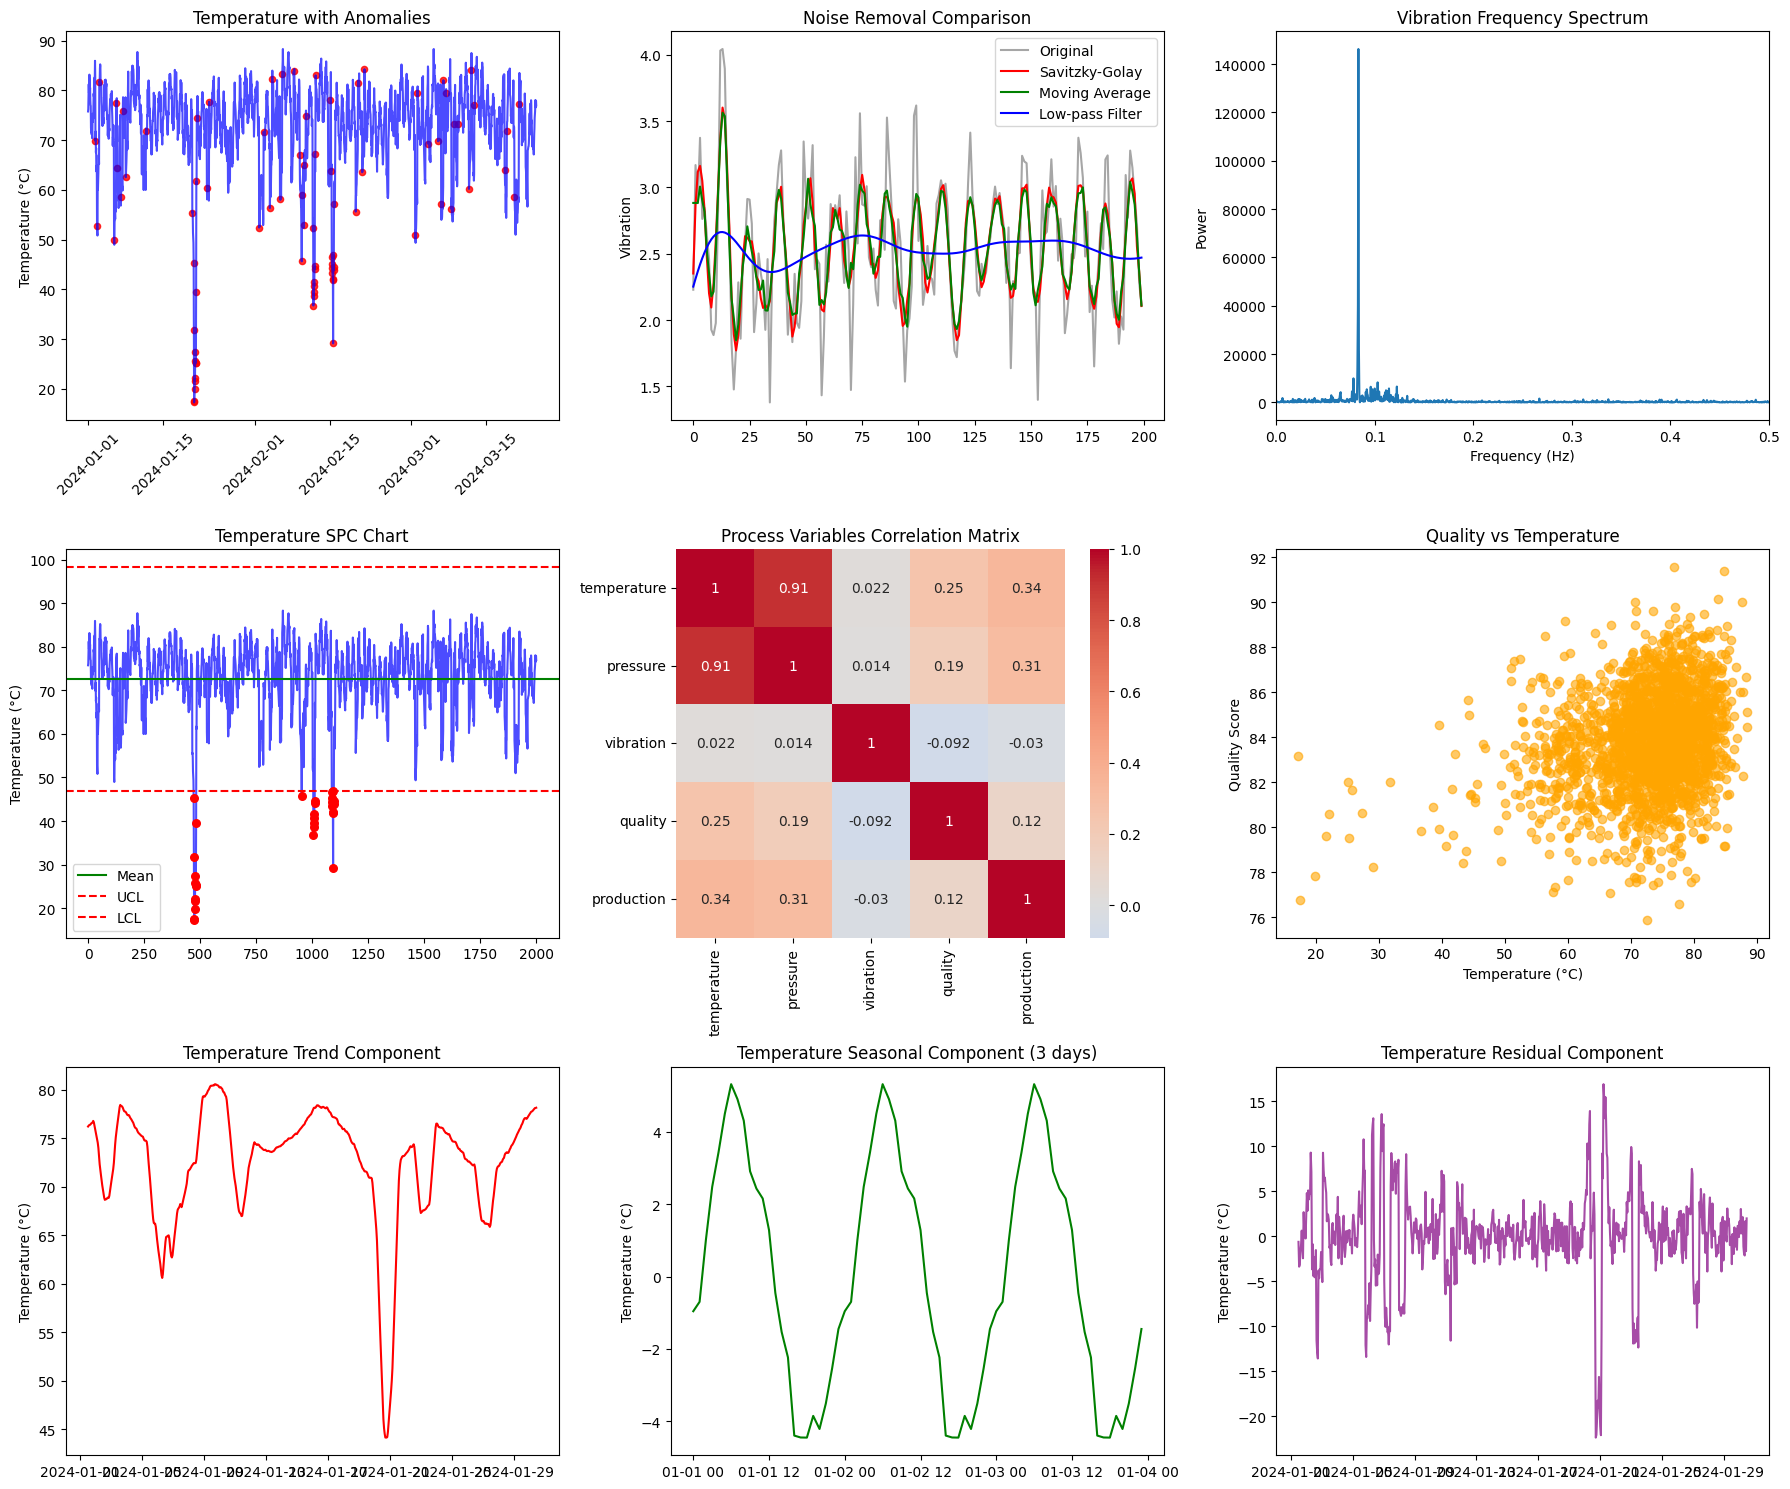

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 시계열 플롯 (온도 + 이상치)
axes[0,0].plot(industrial_data['timestamp'], industrial_data['temperature'], alpha=0.7, color='blue')
anomaly_times = industrial_data.loc[temp_anomalies['any_anomaly'], 'timestamp']
anomaly_temps = industrial_data.loc[temp_anomalies['any_anomaly'], 'temperature']
axes[0,0].scatter(anomaly_times, anomaly_temps, color='red', s=20, alpha=0.8)
axes[0,0].set_title('Temperature with Anomalies')
axes[0,0].set_ylabel('Temperature (°C)')
axes[0,0].tick_params(axis='x', rotation=45)

# 노이즈 제거 비교
sample_range = slice(0, 200)  # 처음 200개 포인트만
axes[0,1].plot(original_vibration[sample_range], alpha=0.7, label='Original', color='gray')
axes[0,1].plot(smoothed_savgol[sample_range], label='Savitzky-Golay', color='red')
axes[0,1].plot(smoothed_ma[sample_range], label='Moving Average', color='green')
axes[0,1].plot(smoothed_lowpass[sample_range], label='Low-pass Filter', color='blue')
axes[0,1].set_title('Noise Removal Comparison')
axes[0,1].set_ylabel('Vibration')
axes[0,1].legend()

# 주파수 스펙트럼
positive_mask = freq_analysis['frequencies'] > 0
axes[0,2].plot(freq_analysis['frequencies'][positive_mask], 
               freq_analysis['power_spectrum'][positive_mask])
axes[0,2].set_title('Vibration Frequency Spectrum')
axes[0,2].set_xlabel('Frequency (Hz)')
axes[0,2].set_ylabel('Power')
axes[0,2].set_xlim(0, 0.5)

# SPC 차트 (온도)
axes[1,0].plot(industrial_data['temperature'], alpha=0.7, color='blue')
axes[1,0].axhline(temp_spc['control_limits']['mean'], color='green', linestyle='-', label='Mean')
axes[1,0].axhline(temp_spc['control_limits']['ucl'], color='red', linestyle='--', label='UCL')
axes[1,0].axhline(temp_spc['control_limits']['lcl'], color='red', linestyle='--', label='LCL')
out_of_control_points = industrial_data.loc[temp_spc['out_of_control'], 'temperature']
out_of_control_indices = industrial_data.index[temp_spc['out_of_control']]
axes[1,0].scatter(out_of_control_indices, out_of_control_points, color='red', s=30, zorder=5)
axes[1,0].set_title('Temperature SPC Chart')
axes[1,0].set_ylabel('Temperature (°C)')
axes[1,0].legend()

# 상관관계 히트맵
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=axes[1,1])
axes[1,1].set_title('Process Variables Correlation Matrix')

# 품질 vs 공정 변수 산점도
axes[1,2].scatter(industrial_data['temperature'], industrial_data['quality'], 
                 alpha=0.6, color='orange')
axes[1,2].set_title('Quality vs Temperature')
axes[1,2].set_xlabel('Temperature (°C)')
axes[1,2].set_ylabel('Quality Score')

# 시계열 분해 (온도 데이터)
# 짧은 기간 데이터로 분해
temp_short = industrial_data['temperature'][:720]  # 30일 데이터
temp_series = pd.Series(temp_short.values, 
                       index=pd.date_range('2024-01-01', periods=len(temp_short), freq='H'))

try:
    decomposition = seasonal_decompose(temp_series, model='additive', period=24)
    
    axes[2,0].plot(decomposition.trend.dropna(), color='red')
    axes[2,0].set_title('Temperature Trend Component')
    axes[2,0].set_ylabel('Temperature (°C)')
    
    axes[2,1].plot(decomposition.seasonal[:72], color='green')  # 3일치 계절성
    axes[2,1].set_title('Temperature Seasonal Component (3 days)')
    axes[2,1].set_ylabel('Temperature (°C)')
    
    axes[2,2].plot(decomposition.resid.dropna(), color='purple', alpha=0.7)
    axes[2,2].set_title('Temperature Residual Component')
    axes[2,2].set_ylabel('Temperature (°C)')
    
except Exception as e:
    # 분해 실패시 대체 플롯
    axes[2,0].plot(temp_short, color='blue')
    axes[2,0].set_title('Temperature Time Series')
    axes[2,0].set_ylabel('Temperature (°C)')
    
    axes[2,1].hist(temp_short, bins=30, alpha=0.7, color='green')
    axes[2,1].set_title('Temperature Distribution')
    axes[2,1].set_ylabel('Frequency')
    
    axes[2,2].plot(np.diff(temp_short), color='purple', alpha=0.7)
    axes[2,2].set_title('Temperature Changes')
    axes[2,2].set_ylabel('Temperature Difference')

plt.tight_layout()
plt.show()


8. 고급 분석: 다변량 이상치 탐지


In [11]:
print(f"\n=== 다변량 이상치 탐지 (PCA 기반) ===")
# 수치형 변수만 선택
numeric_data = industrial_data[['temperature', 'pressure', 'vibration', 'quality', 'production']].values

# 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# PCA
pca = PCA(n_components=3)
pca_data = pca.fit_transform(scaled_data)

# PCA 공간에서 이상치 탐지 (마할라노비스 거리)
mean_pca = np.mean(pca_data, axis=0)
cov_pca = np.cov(pca_data.T)
inv_cov_pca = np.linalg.inv(cov_pca)

# 마할라노비스 거리 계산
mahal_distances = []
for point in pca_data:
    diff = point - mean_pca
    mahal_dist = np.sqrt(diff.T @ inv_cov_pca @ diff)
    mahal_distances.append(mahal_dist)

mahal_distances = np.array(mahal_distances)

# 임계값 (카이제곱 분포의 99% 백분위수)
threshold = np.sqrt(stats.chi2.ppf(0.99, 3))
multivariate_outliers = mahal_distances > threshold

print(f"PCA 설명 분산비: {pca.explained_variance_ratio_}")
print(f"누적 설명 분산: {np.cumsum(pca.explained_variance_ratio_)}")
print(f"다변량 이상치: {multivariate_outliers.sum()}개 ({multivariate_outliers.sum()/len(industrial_data)*100:.2f}%)")



=== 다변량 이상치 탐지 (PCA 기반) ===
PCA 설명 분산비: [0.43831231 0.21180518 0.17334314]
누적 설명 분산: [0.43831231 0.65011749 0.82346063]
다변량 이상치: 50개 (2.50%)


9. 데이터 품질 평가 메트릭

In [12]:
class DataQualityMetrics:
    """데이터 품질 평가를 위한 메트릭"""
    
    @staticmethod
    def completeness(data):
        """완전성: 결측치 비율"""
        return (1 - data.isnull().sum().sum() / (data.shape[0] * data.shape[1])) * 100
    
    @staticmethod
    def consistency(data, column_pairs):
        """일관성: 관련 변수 간 논리적 일관성"""
        inconsistencies = 0
        total_checks = 0
        
        for col1, col2, relationship in column_pairs:
            if relationship == 'positive_correlation':
                # 양의 상관관계가 있어야 하는데 음의 상관관계인 경우
                corr = data[col1].corr(data[col2])
                if corr < 0:
                    inconsistencies += 1
                total_checks += 1
        
        return (1 - inconsistencies / total_checks) * 100 if total_checks > 0 else 100
    
    @staticmethod
    def validity(data, column_ranges):
        """유효성: 값이 유효 범위 내에 있는지"""
        valid_count = 0
        total_count = 0
        
        for column, (min_val, max_val) in column_ranges.items():
            if column in data.columns:
                valid = ((data[column] >= min_val) & (data[column] <= max_val)).sum()
                valid_count += valid
                total_count += len(data[column])
        
        return (valid_count / total_count) * 100 if total_count > 0 else 100
    
    @staticmethod
    def accuracy_via_control_limits(data, control_limits):
        """정확성: 통계적 관리한계 기준"""
        accurate_count = 0
        total_count = 0
        
        for column, limits in control_limits.items():
            if column in data.columns:
                within_limits = ((data[column] >= limits['lcl']) & 
                               (data[column] <= limits['ucl'])).sum()
                accurate_count += within_limits
                total_count += len(data[column])
        
        return (accurate_count / total_count) * 100 if total_count > 0 else 100

In [13]:
# 데이터 품질 평가
dq_metrics = DataQualityMetrics()

# 완전성 평가
completeness_score = dq_metrics.completeness(industrial_data)

# 일관성 평가 (예상되는 관계)
expected_relationships = [
    ('temperature', 'pressure', 'positive_correlation'),
    ('vibration', 'quality', 'positive_correlation')  # 진동이 낮을수록 품질이 높아야 함
]

# 유효성 평가 (산업 표준 범위)
valid_ranges = {
    'temperature': (50, 100),  # °C
    'pressure': (80, 160),     # psi
    'vibration': (0, 10),      # mm/s
    'quality': (0, 100),       # score
    'production': (0, 200)     # units/hour
}

validity_score = dq_metrics.validity(industrial_data, valid_ranges)

# 정확성 평가 (SPC 관리한계 기준)
control_limits_for_accuracy = {
    'temperature': preprocessor.control_limits.get('Temperature', {}),
    'quality': preprocessor.control_limits.get('Quality', {})
}

accuracy_score = dq_metrics.accuracy_via_control_limits(
    industrial_data, control_limits_for_accuracy
)

print(f"\n=== 데이터 품질 평가 결과 ===")
print(f"완전성 (Completeness): {completeness_score:.2f}%")
print(f"유효성 (Validity): {validity_score:.2f}%")
print(f"정확성 (Accuracy): {accuracy_score:.2f}%")
print(f"전체 데이터 품질 점수: {(completeness_score + validity_score + accuracy_score) / 3:.2f}%")


=== 데이터 품질 평가 결과 ===
완전성 (Completeness): 100.00%
유효성 (Validity): 99.61%
정확성 (Accuracy): 99.08%
전체 데이터 품질 점수: 99.56%


10. 전처리 파이프라인 요약 및 권장사항

In [14]:
print(f"\n=== 전처리 파이프라인 요약 및 권장사항 ===")

# 이상치 요약
total_anomalies = (temp_anomalies['any_anomaly'].sum() + 
                  vibration_anomalies['any_anomaly'].sum() + 
                  multivariate_outliers.sum())

print(f"1. 이상치 탐지 결과:")
print(f"   - 온도 센서 이상: {temp_anomalies['any_anomaly'].sum()}개")
print(f"   - 진동 센서 이상: {vibration_anomalies['any_anomaly'].sum()}개")
print(f"   - 다변량 이상치: {multivariate_outliers.sum()}개")
print(f"   - 전체 이상 데이터 비율: {total_anomalies/len(industrial_data)*100:.2f}%")

print(f"\n2. 노이즈 특성:")
print(f"   - 진동 데이터 노이즈 레벨: {original_std:.4f}")
print(f"   - 권장 필터링: Savitzky-Golay (노이즈 {(1-savgol_std/original_std)*100:.1f}% 감소)")

print(f"\n3. 공정 관리 상태:")
print(f"   - 온도: {temp_spc['out_of_control'].sum()}개 포인트가 관리한계 초과")
print(f"   - 품질: {quality_spc['out_of_control'].sum()}개 포인트가 관리한계 초과")

print(f"\n4. 변수 간 관계:")
for corr in strong_correlations:
    print(f"   - {corr['var1']} ↔ {corr['var2']}: {corr['correlation']:.3f}")

print(f"\n5. 전처리 권장사항:")
print(f"   a) 이상치 처리:")
print(f"      - 센서 드리프트: 보정 알고리즘 적용")
print(f"      - 스파이크: 중위값 대체 또는 보간")
print(f"      - 스턱 밸류: 선형 보간 또는 제거")

print(f"\n   b) 노이즈 제거:")
print(f"      - 진동 데이터: Savitzky-Golay 필터 적용")
print(f"      - 온도/압력: 이동평균 또는 저주파 필터")

print(f"\n   c) 특성 공학:")
print(f"      - 시간 기반 특성: 시간대, 요일, 교대조")
print(f"      - 상호작용 특성: 온도×압력, 진동×품질")
print(f"      - 지연 특성: 이전 시점 값들의 영향")

print(f"\n   d) 데이터 분할:")
print(f"      - 시계열 특성 고려하여 시간 순서대로 분할")
print(f"      - 교차 검증시 시계열 CV 사용")

print(f"\n=== 산업 데이터 전처리 실습 완료 ===")
print("다음 단계: 전처리된 데이터를 이용한 예측 모델링")
print("핵심 학습 내용:")
print("1. 산업 환경의 다양한 데이터 특성 이해")
print("2. 센서 데이터 특화 이상 탐지 기법")
print("3. 통계적 공정 관리 적용")
print("4. 다변량 데이터의 상관관계 분석")
print("5. 데이터 품질 평가 메트릭 활용")


=== 전처리 파이프라인 요약 및 권장사항 ===
1. 이상치 탐지 결과:
   - 온도 센서 이상: 84개
   - 진동 센서 이상: 24개
   - 다변량 이상치: 50개
   - 전체 이상 데이터 비율: 7.90%

2. 노이즈 특성:
   - 진동 데이터 노이즈 레벨: 0.5843
   - 권장 필터링: Savitzky-Golay (노이즈 29.9% 감소)

3. 공정 관리 상태:
   - 온도: 30개 포인트가 관리한계 초과
   - 품질: 7개 포인트가 관리한계 초과

4. 변수 간 관계:
   - temperature ↔ pressure: 0.907

5. 전처리 권장사항:
   a) 이상치 처리:
      - 센서 드리프트: 보정 알고리즘 적용
      - 스파이크: 중위값 대체 또는 보간
      - 스턱 밸류: 선형 보간 또는 제거

   b) 노이즈 제거:
      - 진동 데이터: Savitzky-Golay 필터 적용
      - 온도/압력: 이동평균 또는 저주파 필터

   c) 특성 공학:
      - 시간 기반 특성: 시간대, 요일, 교대조
      - 상호작용 특성: 온도×압력, 진동×품질
      - 지연 특성: 이전 시점 값들의 영향

   d) 데이터 분할:
      - 시계열 특성 고려하여 시간 순서대로 분할
      - 교차 검증시 시계열 CV 사용

=== 산업 데이터 전처리 실습 완료 ===
다음 단계: 전처리된 데이터를 이용한 예측 모델링
핵심 학습 내용:
1. 산업 환경의 다양한 데이터 특성 이해
2. 센서 데이터 특화 이상 탐지 기법
3. 통계적 공정 관리 적용
4. 다변량 데이터의 상관관계 분석
5. 데이터 품질 평가 메트릭 활용
